In [199]:
from rosbags.rosbag2 import Reader, Writer
from rosbags.serde import deserialize_cdr, serialize_cdr
from rosbags.typesys import get_types_from_idl, get_types_from_msg, register_types

from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

import sys
sys.path.append('/home/minoda/git/deep_localizability_estimation/utils')
from read_pointcloud2 import read_points

In [57]:
# Need to contain /koji_debugging/wHOGE, /localization/twist_estimator/twist
bag_path = '/home/minoda/data/rosbags/processed/jpntaxi/jt02-odaiba-2022-06-17'

!ros2 bag info $bag_path
# !source /home/minoda/git/autoware.proj.jpntaxi.universe/install/setup.bash


Files:             localized_scans_0.db3
Bag size:          93.3 MiB
Storage id:        sqlite3
Duration:          287.950s
Start:             Nov  6 2022 15:10:18.967 (1667715018.967)
End:               Nov  6 2022 15:15:06.918 (1667715306.918)
Messages:          59684
Topic information: Topic: /localization/pose_estimator/transform_probability | Type: tier4_debug_msgs/msg/Float32Stamped | Count: 0 | Serialization Format: cdr
                   Topic: /localization/pose_estimator/points_aligned | Type: sensor_msgs/msg/PointCloud2 | Count: 2785 | Serialization Format: cdr
                   Topic: /localization/kinematic_state | Type: nav_msgs/msg/Odometry | Count: 14381 | Serialization Format: cdr
                   Topic: /clock | Type: rosgraph_msgs/msg/Clock | Count: 0 | Serialization Format: cdr
                   Topic: /localization/twist_estimator/twist_with_covariance | Type: geometry_msgs/msg/TwistWithCovarianceStamped | Count: 8181 | Serialization Format: cdr
              

# LiDAR scan

In [165]:
scans_list = []
odom_list = []

with Reader(bag_path) as reader:
    for connection, timestamp, raw_data in tqdm(reader.messages()):
        if connection.topic == '/localization/pose_estimator/points_aligned':
            msg = deserialize_cdr(raw_data, connection.msgtype)
            points = np.array(list(read_points(msg)))
            scans_list.append(points)
        if connection.topic == '/localization/kinematic_state':
            msg = deserialize_cdr(raw_data, connection.msgtype)
            odom_list.append([
                msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9,
                msg.pose.pose.position.x,
                msg.pose.pose.position.y,
                msg.pose.pose.position.z,
                msg.pose.pose.orientation.x,
                msg.pose.pose.orientation.y,
                msg.pose.pose.orientation.z,
                msg.pose.pose.orientation.w,
            ])

59684it [00:03, 17502.63it/s]


# Pointcloud map

In [73]:
pcd = o3d.io.read_point_cloud("/home/minoda/data/maps/odaiba/pointcloud_map/pointcloud_map.pcd")
points_map = np.asarray(pcd.points)

# Compare

In [169]:
class RandomTransformer:
    def __init__(self):
        self.max_dist_variance = 10
        # self.max_yaw_variance = 0.5
    
    def transform(self, points_input):
        points = points_input.copy()
        dx = self.max_dist_variance * (np.random.rand() * 2 - 1)
        dy = self.max_dist_variance * (np.random.rand() * 2 - 1)
        points[:, 0] += dx
        points[:, 1] += dy
        # dyaw = self.max_yaw_variance * (np.random.rand() * 2 - 1)
        # matrix = np.array([
        #     [np.cos(dyaw), -np.sin(dyaw), dx],
        #     [np.sin(dyaw), np.cos(dyaw), dy],
        #     [0., 0., 1.],
        # ])
        # points_xy = np.ones_like(points)
        # points_xy[:, 0:2] = points[:, 0:2]
        # print(points_xy.shape, matrix.shape)
        # points[:, 0:2] = (points_xy @ matrix)[:, 0:2]
        return points

In [192]:
idx = 950
make_invalid = True
random_transformer = RandomTransformer()

In [196]:
points = scans_list[idx]
if make_invalid:
    points = random_transformer.transform(points)

In [197]:
min_x = np.min(points[:, 0])
max_x = np.max(points[:, 0])
min_y = np.min(points[:, 1])
max_y = np.max(points[:, 1])
points_map_neighbors = points_map[
    (points_map[:, 0] > min_x) &
    (points_map[:, 0] < max_x) &
    (points_map[:, 1] > min_y) &
    (points_map[:, 1] < max_y)]

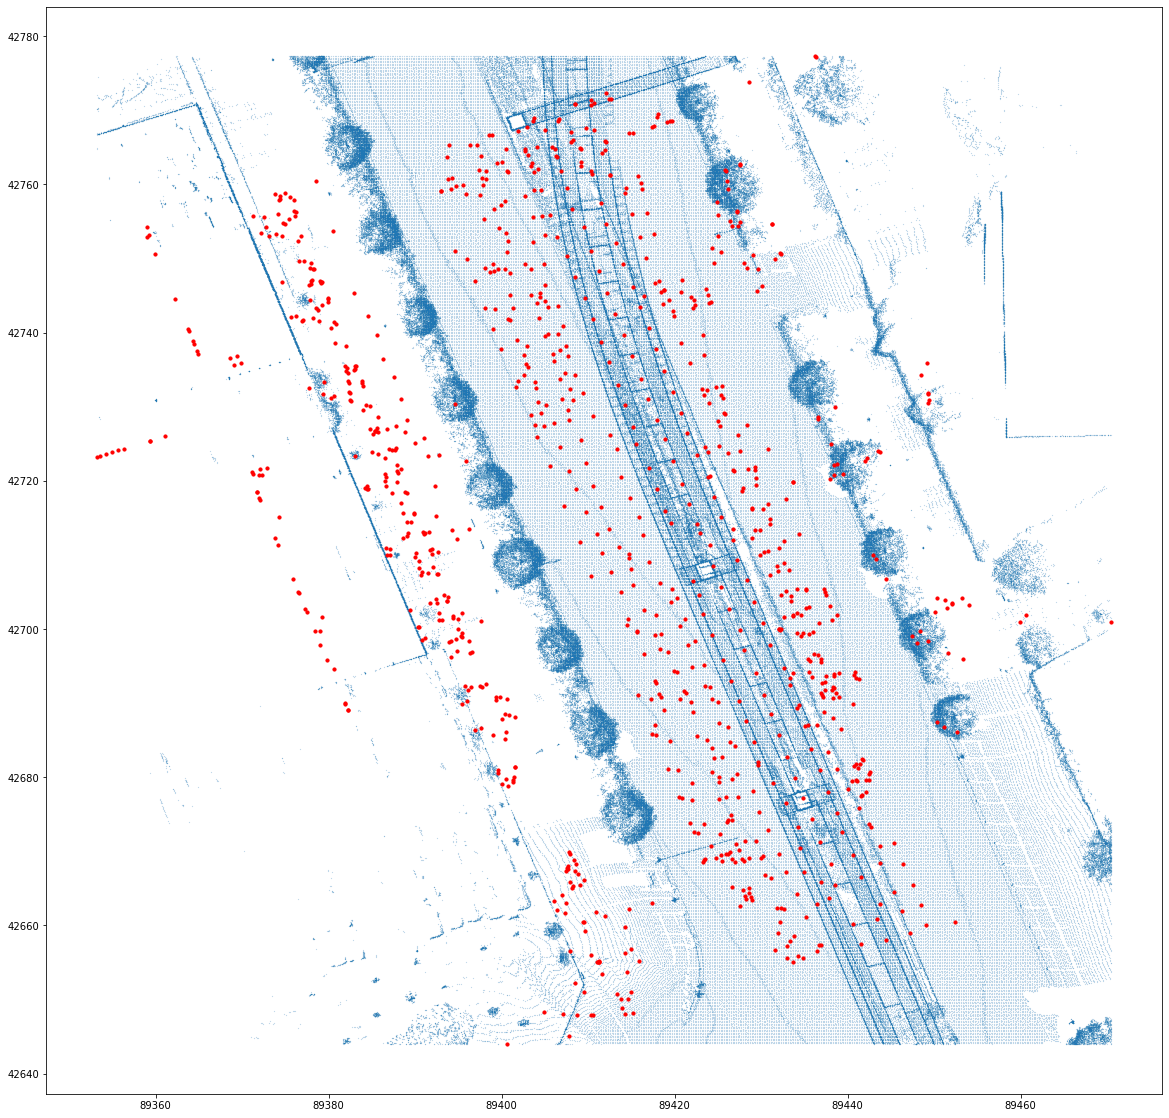

In [198]:
plt.figure(figsize=(20, 20))
plt.scatter(points_map_neighbors[:, 0], points_map_neighbors[:, 1], s=0.01)
plt.scatter(points[:, 0], points[:, 1], s=10, color='red')
if make_invalid:
    plt.savefig('outputs/figures/sample_invalid_{}.png'.format(idx), dpi=200)
else:
    plt.savefig('outputs/figures/sample_valid_{}.png'.format(idx), dpi=200)